In [1]:
# We require to install the following packages:
# !pip install torchaudio librosa

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

1.11.0
0.11.0


# Espectrogramas de un tono puro

In [2]:
import os
import librosa
import matplotlib.pyplot as plt
import requests
from IPython.display import Audio, display

In [3]:
def _fetch_data():
    uri = [
        (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
    ]
    for url, path in uri:
        with open(path, "wb") as file_:
            file_.write(requests.get(url).content)

def _get_sample(path, resample=None):
    effects = [["remix", "1"]]
    if resample:
        effects.extend(
            [
                ["lowpass", f"{resample // 2}"],
                ["rate", f"{resample}"],
            ]
        )
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)


def get_speech_sample(audio_path='', resample=None):
    return _get_sample(audio_path, resample=resample)


def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()


def plot_spectrogram(spec, sample_rate, title=None, ylabel="freq_bin", aspect="auto", xmax=None, mel = False):
    if mel:
        f = torch.linspace(0, spec.shape[0], spec.shape[0]//8+1).numpy()
        b = torch.linspace(0, spec.shape[0], spec.shape[0]//8+1)
    else:
        f = torch.linspace(0, int(sample_rate/2), 7).numpy()
        b = torch.linspace(0, spec.shape[0], 7)
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    axs.set_yticks(b)
    axs.set_yticklabels(f)
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)


def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")


def plot_mel_fbank(fbank, sample_rate, title=None):
    f = torch.linspace(0, int(sample_rate/2), 7).numpy()
    b = torch.linspace(0, fbank.shape[0], 7)
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency Hz")
    axs.set_xlabel("mel bin")
    axs.set_yticks(b)
    axs.set_yticklabels(f)
    plt.show(block=False)

In [4]:
_SAMPLE_DIR  = "_assets"
audio_path_10k = os.path.join(_SAMPLE_DIR, "10kHz_44100Hz_16bit_05sec.wav")
os.makedirs(_SAMPLE_DIR, exist_ok=True)

In [5]:
waveform1, sample_rate = get_speech_sample(audio_path_10k)

## Espectrograma en escala de frecuencia lineal Hz

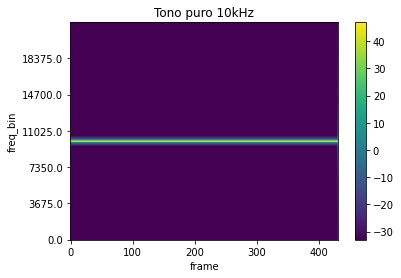

In [6]:
#%matplotlib notebook

n_fft      = 1024
win_length = None
hop_length = 512

# define transformation
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# Perform transformation
spec = spectrogram(waveform1)

#print_stats(spec)
plot_spectrogram(spec[0], sample_rate, title="Tono puro 10kHz")

## Banco de filtros en escala Mel

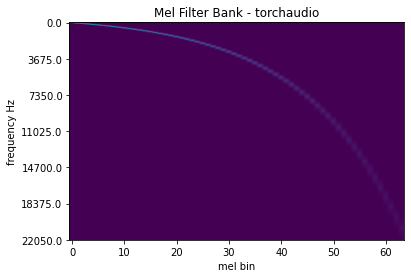

In [7]:
n_fft  = 1024
n_mels = 64

mel_filters = F.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    norm="slaney",
)
plot_mel_fbank(mel_filters, sample_rate, "Mel Filter Bank - torchaudio")

## Espectrograma en escala de frecuencia Mel

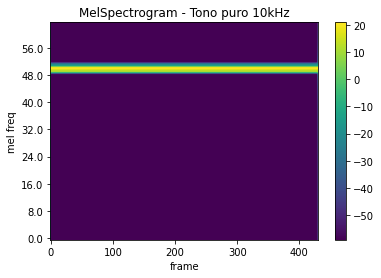

In [8]:
waveform, sample_rate = get_speech_sample(audio_path_10k)

n_fft = 1024
win_length = None
hop_length = 512
n_mels = 64

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(waveform)
plot_spectrogram(melspec[0], sample_rate, title="MelSpectrogram - Tono puro 10kHz", ylabel="mel freq", mel = True)